# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Define our question, understanding the Datasets, Data preprocessing, EDA, model the data, compare various ML algorithms, and finally selecting one model and improving it.

People saw the model, then used (both are counted as interactions), the question is which one is the pirority? Increase exposure or increase spending? (the business cost and return to increase exposure vs. the business return and cost to increase spending)

Questions I want to ask are:
- How do people responde to the offer on average
- Any difference if we divide by gender/age/income vs. offer given channel/duration/values 

multiclass classification

# 1. Inspect the Dataset:

In [1]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.sample(5)

,gender,age,id,became_member_on,income
12373,M,24,78e971bddb2842208b226249593b424f,20171017,72000.0
770,M,49,f6bd6dc5dc074183af8248e31c960ce5,20170512,75000.0
11573,M,27,ab1d3eaeba2f46ff8253951c26994cdb,20151104,59000.0
1326,M,65,81af83e08a7d48deaaf764753e2810b3,20170408,35000.0
14604,M,33,6ac3a35e06d848e9b02ec09e74d1ff7b,20180429,53000.0


In [3]:
transcript.sample(5)

,person,event,value,time
234372,3df2d3180bcd4876a3abb7035a3bcb5d,transaction,{'amount': 10.24},540
136948,d7f94cafc2e5434d9d12cd5da0bf5fa1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},360
41121,d95370555c8145d6a463b7d8a8adffee,transaction,{'amount': 2.26},96
159131,24e1795cb9894e078644210adf514d18,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},408
125762,3964c9d017984279866a8496b9cd2156,transaction,{'amount': 5.08},336


In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


To do any analysis, we will need to combine the 3 dataset. We will clean the profile and transcript dataset first, and merge combine them. Then we will combine it with portfolio. Let's start with cleaning the profile dataset.

Due to the limited demographic data, it seems that demographic does not make a huge difference in terms of the offer. It will be betterif we use user behaviors, like their past expeirence with rewards program.

Therefore, I want to investigate if the type of the offer impacts people in general? (for example, the channel impacts whether people will view the transaction. If other factors impact / incentives their rate)

type of offer vs. value amount vs. relationship with income or demographics

I will perdict if the member will use the offer

## 2. Cleaning the Datasets

### 2.1: Profile and Transcript Datasets

In [5]:
profile.info() #inspect the datatype and null vlaues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


* gender and income - has the same amount of null values
* became_member_on - not in datatime format

In [6]:
profile.describe() #inspect the values

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


* age - max value is 118

In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


* value - needs to be seperated by offer_id and amount

In [8]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


* time - in hours, will be easier to see if change to days.

In [9]:
#merge the two dataset
df = transcript.merge(profile, left_on='person', right_on='id', how='outer')

In [10]:
#let's look at the null values first
null_profile = df[df['gender'].isnull()]

null_profile.sample(5)

,person,event,value,time,gender,age,id,became_member_on,income
214953,8dd102d906ef46aebcbe8a3bfb8a9760,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,None,118,8dd102d906ef46aebcbe8a3bfb8a9760,20171204,NaN
62334,edddd144020249c381fee7be612e7b6d,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,666,None,118,edddd144020249c381fee7be612e7b6d,20170815,NaN
102163,ed652dee45c042cc99eb591f2f210b65,transaction,{'amount': 6.52},642,None,118,ed652dee45c042cc99eb591f2f210b65,20160426,NaN
11110,85240db9bdca4e5486b9837ae5ceea59,transaction,{'amount': 1.8},576,None,118,85240db9bdca4e5486b9837ae5ceea59,20171112,NaN
222097,2c8adcf84d1643628f893c2084e3d3fd,transaction,{'amount': 4.4},444,None,118,2c8adcf84d1643628f893c2084e3d3fd,20171211,NaN


In [11]:
#confirm if null values in gender == null in income
null_profile['income'].mean()

nan

In [12]:
#confirm if all null values has age == 118
null_profile['age'].mean()

118.0

In [13]:
#do null profiles ever completed any offers?
null_profile['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [14]:
#null profile offer completion rate
len(null_profile[null_profile['event']=='offer completed'])/len(null_profile[null_profile['event']=='offer received'])

0.11610065466448445

In [15]:
#complete profile offer completion rate
com_profile = df[df['gender'].notnull()]

len(com_profile[com_profile['event']=='offer completed'])/len(com_profile[com_profile['event']=='offer received'])

0.4878723628216117

**Insight 1: If a customer has an incomplete profile, for example, with missing gender or age, the chance of that customer participating in an offer is significantly lower.**

Due to the incomplete information and they are significantly less likely to use our offer. I decided to drop them for now. However, I did make the assumption that they are likely to spend less money as well due to the low degree of participation/invovlement, without analysising the amount of transaction that they made.

### 2.1.1: Round 1 - correct data types and formats

In [16]:
def clean_profile(df):
    clean_df = df[df['gender'].notnull()].copy() #drop null values
    clean_df.drop('id', axis=1, inplace=True) #drop the repeated column after combine
    
    #change became_member_on to datetime formate
    clean_df['became_member_on'] = pd.to_datetime(clean_df['became_member_on'], format='%Y%m%d')
    
    #change the time in hours to days, rounding up
    clean_df['days'] = clean_df['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
    
    #clean the value column
    clean_df['offer_id'] = clean_df['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)
    clean_df['amount'] = clean_df['value'].apply(lambda x: x.get('amount', 0))
    clean_df.drop(['value'], axis=1, inplace=True)
    
    clean_df = clean_df.reset_index(drop=True)
    
    return clean_df
    

In [17]:
clean_df = clean_profile(df)
clean_df.head()

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,2017-05-09,100000.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,2017-05-09,100000.0,6,NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,2017-05-09,100000.0,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,2017-05-09,100000.0,6,NaN,17.78


### 2.2 Portfolio Dataset

In [18]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [19]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


* channel - in a list, make them very hard to analyze
* no null values - good

In [20]:
portfolio['channels'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [21]:
#merge the three datasets
full_df = clean_df.merge(portfolio, left_on='offer_id', right_on='id', how='outer')
full_df.drop(['id'], axis=1, inplace=True) #drop the repeated column
full_df.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type
174025,2fdc2ef2bd9547a2b2327de3b045d9bc,offer received,408,F,57,2016-08-29,53000.0,17,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,"[web, email, mobile, social]",5.0,5.0,bogo
185270,23b724c1f63849088971c3f94cc839af,offer received,576,F,69,2016-07-23,36000.0,24,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,"[web, email, mobile]",10.0,7.0,discount
246182,d7fec020017649a7a13a924c04e8c07b,offer received,168,F,36,2018-01-03,40000.0,7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,"[web, email]",20.0,10.0,discount
114871,687647a3973e4acb80441a1a1e6aee3a,transaction,210,F,90,2016-03-10,93000.0,9,NaN,17.63,NaN,NaN,NaN,NaN,NaN
149821,2b05fa3fb6d042d6abbc803653e7399c,offer received,336,M,54,2017-10-20,60000.0,14,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,"[email, mobile, social]",0.0,3.0,informational


In [22]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   gender            272762 non-null  object        
 4   age               272762 non-null  int64         
 5   became_member_on  272762 non-null  datetime64[ns]
 6   income            272762 non-null  float64       
 7   days              272762 non-null  int64         
 8   offer_id          148805 non-null  object        
 9   amount            272762 non-null  float64       
 10  reward            148805 non-null  float64       
 11  channels          148805 non-null  object        
 12  difficulty        148805 non-null  float64       
 13  duration          148805 non-null  float64       
 14  offe

### 2.3 full dataset

### 2.3.1: Round 2 - turn categorical data to numerical for analysis

* event - 
    - 0-'offer received'
    - 1-'offer viewed'
    - 2-'offer completed'
    - 3-'transaction'
* gender - 
    - 0-F
    - 1-M
    - 3-O
* channels - 
    - 3-[web, email, mobile, social]    
    - 2-[web, email, mobile]            
    - 1-[email, mobile, social]         
    - 0-[web, email]                   
* offer_type - 
    - 0-'bogo'
    - 2-'informational'
    - 3-'discount'

In [23]:
print((full_df['offer_type'].unique()), (full_df['event'].unique()), full_df['gender'].unique())

['bogo' nan 'informational' 'discount'] ['offer received' 'offer viewed' 'offer completed' 'transaction'] ['F' 'M' 'O']


In [24]:
def cate2num(df, cols):
    for col in cols:
        array = df[col].unique()
        value_nums = len(array)
        length = len(df)
        df[col+'_id'] = df[col]

        for i in range(value_nums):
            df[col+'_id'] = np.where(df[col] == array[i] , i, df[col+'_id'])
    
    return df


In [25]:
cols = ['gender', 'event', 'offer_type']
full_clean = cate2num(full_df, cols)
full_clean.sample(10)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id
217524,59117e97e0424ab89455dc9607b9b7e7,offer received,408,M,66,2014-10-21,66000.0,17,fafdcd668e3743c1bb461111dcafc2a4,0.00,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,0,3
53801,7eef6a95040a49e2aa8863beb943d381,transaction,552,F,77,2017-04-24,66000.0,23,NaN,28.22,NaN,NaN,NaN,NaN,NaN,0,3,NaN
56413,05037de294c540d3ba92aa627b992066,transaction,126,M,28,2015-05-30,62000.0,6,NaN,0.74,NaN,NaN,NaN,NaN,NaN,1,3,NaN
168438,bb465e90882143b6a49f99d9d810dc3f,offer completed,624,F,53,2015-08-07,75000.0,26,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,0,2,0
149118,40ffe62904854748b1b19de2233e38e5,offer received,576,F,76,2018-03-18,79000.0,24,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,"[email, mobile, social]",0.0,3.0,informational,0,0,2
14211,3aceb78293b742efbcf93b03af4c83fc,offer received,336,M,21,2018-03-06,63000.0,14,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,0,0
41875,8119a36f32e94a8ab2d1e94cd5df0a99,transaction,54,F,20,2017-10-09,45000.0,3,NaN,26.61,NaN,NaN,NaN,NaN,NaN,0,3,NaN
176131,633815975da245bb83537702f1ffa118,offer received,0,M,59,2016-05-03,79000.0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0
153340,4cd5bafcaf6b4f42a1fd16d19d14b6c4,offer completed,330,F,54,2018-04-25,65000.0,14,ae264e3637204a6fb9bb56bc8210ddfd,0.00,10.0,"[email, mobile, social]",10.0,7.0,bogo,0,2,0
94606,89507aca336640968fbee05111d881da,transaction,306,F,29,2017-09-01,54000.0,13,NaN,6.84,NaN,NaN,NaN,NaN,NaN,0,3,NaN


In [26]:
def create_channelId(df, col):
    channelTye_id = df[col].copy()
    length = len(df)
    
    for x in range(length):
        if df[col][x] == ['web', 'email', 'mobile', 'social']:
            channelTye_id[x] = 3
        elif df[col][x] == ['web', 'email', 'mobile']:
            channelTye_id[x] = 2
        elif df[col][x] == ['email', 'mobile', 'social']:
            channelTye_id[x] = 1
        elif df[col][x] == ['web', 'email']:
            channelTye_id[x] = 0
            
    df['channelTye_id'] = channelTye_id

    return df


In [27]:
full_clean = create_channelId(full_clean, 'channels')

full_clean.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id
20145,745317293ddf44fa853a38aee9d1e032,transaction,12,F,20,2016-12-24,62000.0,1,NaN,20.76,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN
28487,940782f40a554a4da1b827f52de8b478,transaction,690,M,59,2014-09-03,66000.0,29,NaN,2.47,NaN,NaN,NaN,NaN,NaN,1,3,NaN,NaN
149812,afc2ba5bfc134860bb972db2a7919901,offer received,336,F,56,2017-12-06,60000.0,14,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,"[email, mobile, social]",0.0,3.0,informational,0,0,2,1
83025,f40d6cee844544ae829e48798f635631,transaction,474,F,94,2017-03-26,85000.0,20,NaN,39.09,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN
126381,cbd2e79f58364023a5cc205c9cccafc9,transaction,366,M,58,2013-10-21,53000.0,16,NaN,1.91,NaN,NaN,NaN,NaN,NaN,1,3,NaN,NaN


### 2.3.2: Round 3 - seperate into different datasets

In [29]:
#df with only offer records
offer_df = full_clean[full_clean['offer_id'].notnull()]

#df with only bogo and discount offer type
offer0_3 = full_clean.loc[(full_clean['offer_type_id']==0) | (full_clean['offer_type_id']==3)]

#df with only promotional offer and trasctions
offer2_n_amount = full_clean[(full_clean['offer_type_id']!=0) & (full_clean['offer_type_id']!=3)]

#df with only transational record
amount_df = full_clean[full_clean['amount'].notnull()]

In [30]:
offer_df.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id
261417,d5dc6ef114ba4aa69b091e6131a99f9b,offer viewed,174,F,74,2017-11-21,85000.0,8,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,0,1,0,3
232649,a7aca0114d2145a687d726e9d6f35b83,offer received,504,M,43,2017-01-09,31000.0,21,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,1,0,3,3
233975,c33b34ac9d994cbfb5237c86e9e0b44d,offer viewed,186,M,26,2018-04-19,52000.0,8,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,1,1,3,3
218333,6cd32ababc644c6c8a2644368c795728,offer viewed,504,M,68,2014-12-11,54000.0,21,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,1,3,3
229050,4384b18804874776b628f5d6a390e2d4,offer viewed,18,F,36,2017-06-25,70000.0,1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,0,1,3,3


In [31]:
offer0_3.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id
181340,54ddebb6c4a744fab1b222aabf7581f6,offer received,336,M,61,2017-08-02,35000.0,14,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3
247744,d57fbb84ef4e412e8cdb25f4fbbfe339,offer received,168,F,54,2015-08-15,49000.0,7,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,0,0,3,0
174545,10cdcf9677bf4ee382d6395f4715686a,offer received,504,M,74,2017-02-17,85000.0,21,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3
9587,2ed716a7260e4460a62282bd9ed57a96,offer received,0,M,46,2017-09-07,59000.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,0,0,2
182528,4c4ef31a68624cbbb92d813c24b1aef8,offer completed,372,F,68,2017-04-21,108000.0,16,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,0,2,0,3


In [34]:
offer2_n_amount.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id
137433,7bfa3b9308be4d40a0d8ec4ca87df770,transaction,450,F,52,2016-06-09,69000.0,19,NaN,18.28,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN
206682,767f0a2faf754fba81af8705f50bece8,offer received,168,F,69,2016-02-12,79000.0,7,3f207df678b143eea3cee63160fa8bed,0.00,0.0,"[web, email, mobile]",0.0,4.0,informational,0,0,2,2
20378,99d0d659823e4fe5a2b9837140fbcc64,transaction,534,F,64,2017-10-12,33000.0,23,NaN,11.31,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN
66204,dd0fe73d5e7b46e98304b1643394fe9e,transaction,354,M,79,2018-01-23,90000.0,15,NaN,18.46,NaN,NaN,NaN,NaN,NaN,1,3,NaN,NaN
68915,d75d44b78f4e4d65bf491ba04c6a49b0,transaction,192,M,71,2017-01-27,90000.0,8,NaN,17.67,NaN,NaN,NaN,NaN,NaN,1,3,NaN,NaN


In [33]:
amount_df.sample(5)

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id
47538,f930b6a55d964983b34daa04e80ba3bf,transaction,594,M,46,2014-07-17,58000.0,25,NaN,12.14,NaN,NaN,NaN,NaN,NaN,1,3,NaN,NaN
256599,9aba5058cb4f483da896335a1479a944,offer viewed,210,F,65,2017-09-09,119000.0,9,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,0,1,0,3
157837,2a63c44715f44f728e0fb3b999b63e4d,offer received,168,F,55,2016-11-29,55000.0,7,ae264e3637204a6fb9bb56bc8210ddfd,0.00,10.0,"[email, mobile, social]",10.0,7.0,bogo,0,0,0,1
175597,23cac9b547fe47048c0fe8ac758dc7a7,offer viewed,432,M,64,2017-08-31,57000.0,18,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,1,0,3
219685,8c3375bdfa3348f2a69dafbb675f034d,offer completed,522,F,81,2015-10-28,78000.0,22,fafdcd668e3743c1bb461111dcafc2a4,0.00,2.0,"[web, email, mobile, social]",10.0,10.0,discount,0,2,3,3


### 3. EDA

### Questions:
- investigate discount offer: goal is to find the most not responsive group so that we don't waste money
    1. % of people that used (with and not view) our discount and bogo offer? Difference among groups - which one most responsive vs. not
    responsive
    2. % of our discount and bogo offers that were used after viewing vs. without viewing them? which group has the highest % of using our offer without viewing it?
    
    
- invetigate advertisement offer: goal is to find the most responsive group so that we prompt spending without cost
    3. % of people that viewed our advertisement and does it affect spending behavior? which group is most responsive to advertisement? 
    4. Does after using the discount & bogo offer for the first time also make the clien more responsive to advertisement offer afterwards?

### 3.1 Question about the discount and BOGO offer
**Goal: identify the most irresponsive group so that we don't waste money**

Questions:
- % of people that used (with and not view) our discount and bogo offer? Difference among groups - which one most responsive vs. not responsive
- % of our discount and bogo offers that were used after viewing vs. without viewing them? which group has the highest % of using our offer without viewing it?

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

### 3.1.1: Understand the offers

In [128]:
offer0_3['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    18062
2298d6c36e964ae4a3e7e9706d1fb8c2    17920
f19421c1d4aa40978ebb69ca19b0e20d    16989
ae264e3637204a6fb9bb56bc8210ddfd    16241
4d5c57ea9a6940dd891ad53e9dbe8da0    16232
9b98b8c7a33c4b65b9aebfe6a799e6d9    14372
2906b810c7d4411798c6938adc9daaa5    14002
0b1e1539f2cc45b7b9fa7c272da2e1d7    12327
Name: offer_id, dtype: int64

In [130]:
offer0_3.groupby(['offer_id'])['days'].mean()
offer0_3.groupby(['offer_id'])['days'].min()
offer0_3.groupby(['offer_id'])['days'].max()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    15.363998
2298d6c36e964ae4a3e7e9706d1fb8c2    15.211663
2906b810c7d4411798c6938adc9daaa5    15.166619
4d5c57ea9a6940dd891ad53e9dbe8da0    14.878512
9b98b8c7a33c4b65b9aebfe6a799e6d9    15.291122
ae264e3637204a6fb9bb56bc8210ddfd    14.902531
f19421c1d4aa40978ebb69ca19b0e20d    14.805521
fafdcd668e3743c1bb461111dcafc2a4    15.039807
Name: days, dtype: float64

In [125]:
#how offer is being distributed 
offer0_3['interacted'] = 1

user_item = offer0_3.groupby(['person', 'days','event'])['interacted'].max().unstack(fill_value=0)

<ipython-input-125-25f761bdf43c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer0_3['interacted'] = 1


In [116]:
events = list(offer0_3['event'].unique())

events

['offer received', 'offer viewed', 'offer completed']

Text(0, 0.5, 'count')

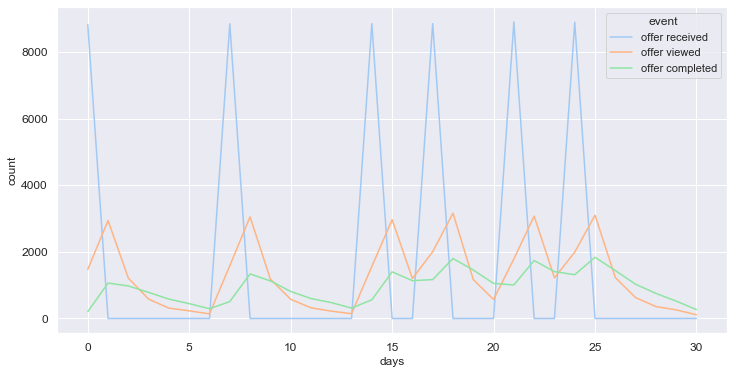

In [127]:
ax = user_item.groupby('days')[events].sum().plot(figsize=(12,6), fontsize=12)
ax.set_xlabel = ('days')
ax.set_ylabel("count")

- The peak of offer viewed and ofer completed sync betteras time goes by. The first and second time, the peak of completed was before the peak of viewed 
- offers are effective in stmulating spending 
- the gap between "offer completed" and "offer viewed" does decrese as time goes by

### 3.1.2 - First Question

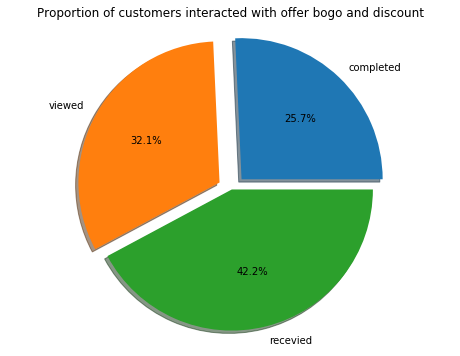

In [36]:
labels = 'completed', 'viewed', 'recevied'
sizes = [len(offer0_3[offer0_3['event_id']==2]), len(offer0_3[offer0_3['event_id']==1]), len(offer0_3[offer0_3['event_id']==0])]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customers interacted with bogo and discount offer")

plt.show()

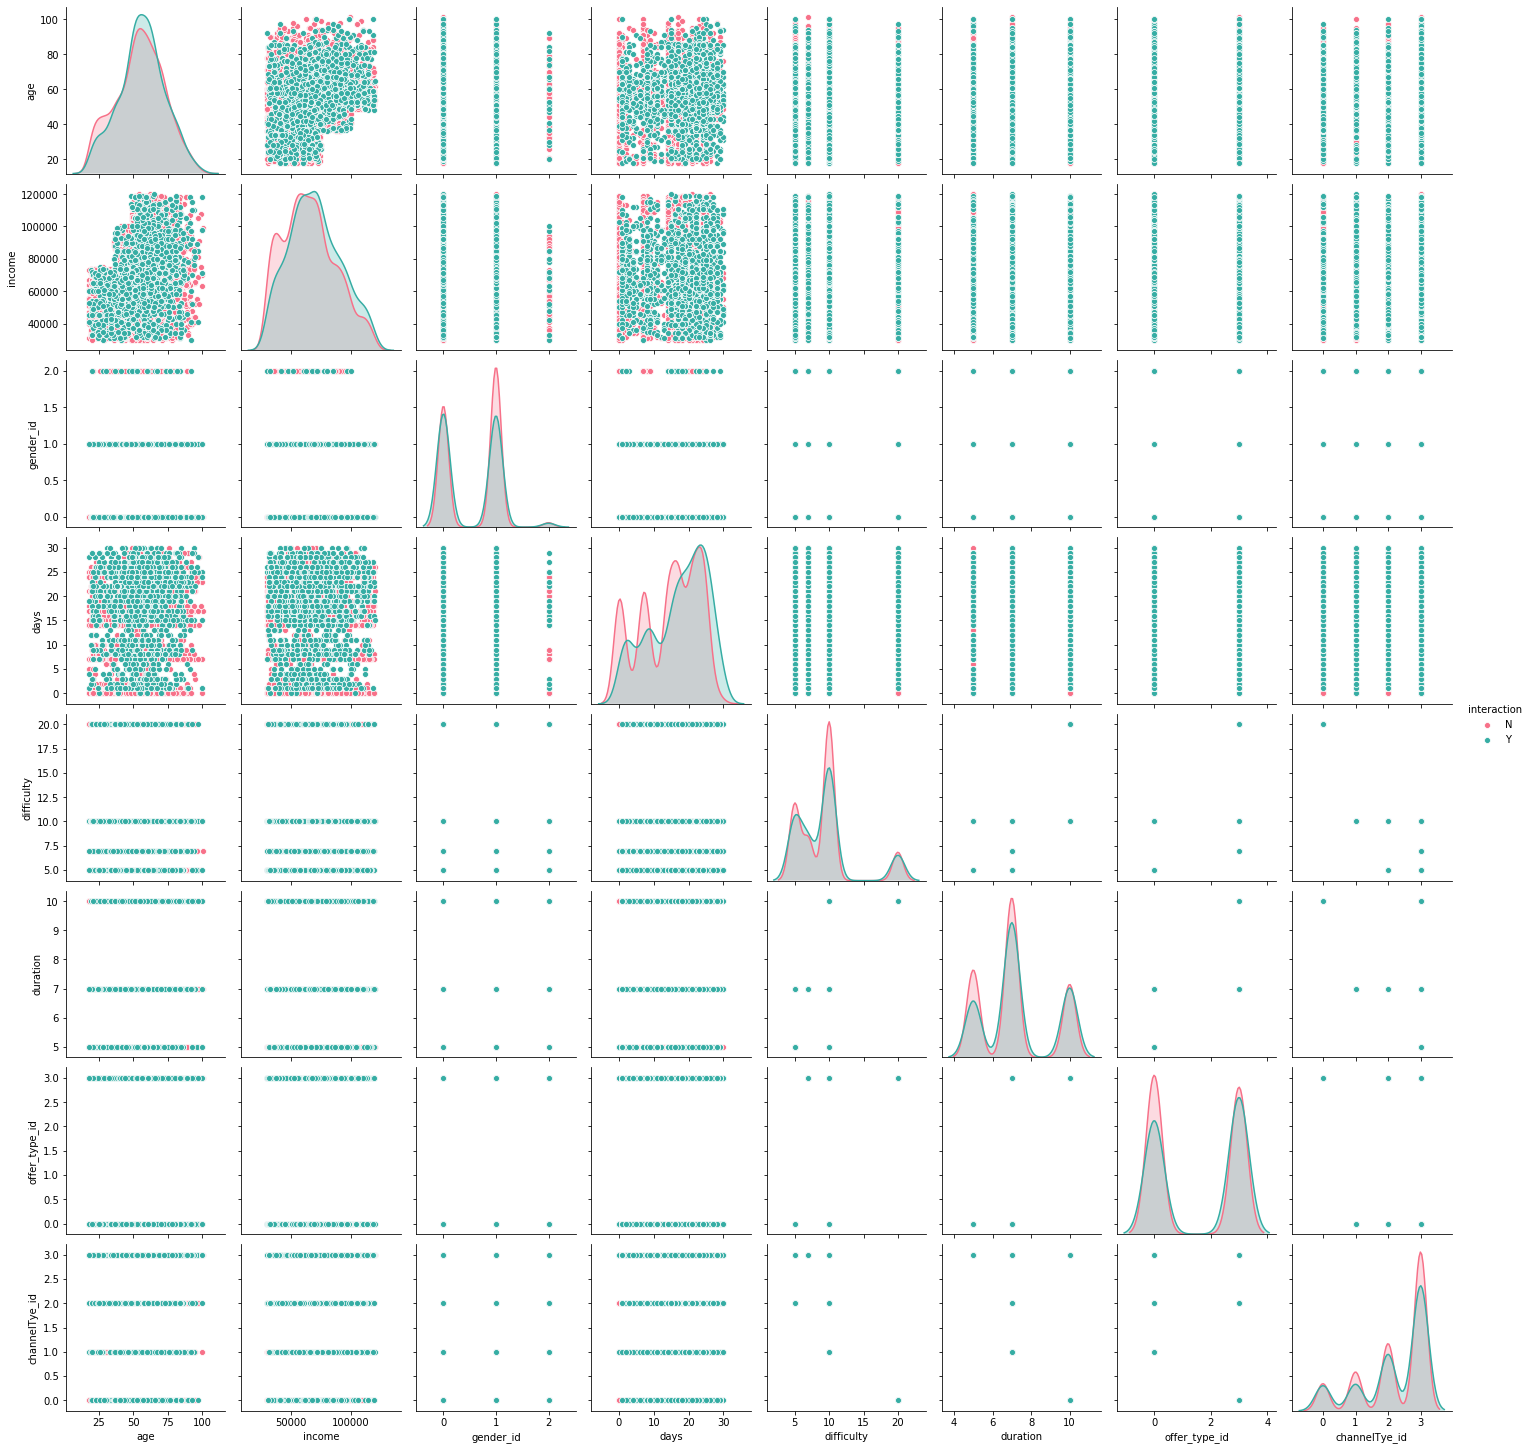

In [59]:
#Let's look at how demographics and the type of offer influence customer's interaction with the offer

#used 3% of the dataset, otherwise it will take too much time to graph it
df_hue = offer0_3.sample(5000).copy()
df_hue["interaction"] = np.where(df_hue["event_id"] == 2, "Y", "N")
df_hue2 = df_hue[["interaction", "age", "income", "gender_id", "days", "difficulty", "duration", "offer_type_id", "channelTye_id"]]

sns.pairplot(df_hue2, hue="interaction", palette="husl")

Reminder:

* event - 
    - 0-'offer received'
    - 1-'offer viewed'
    - 2-'offer completed'
    - 3-'transaction'
* gender - 
    - 0-F
    - 1-M
    - 3-O
* channels - 
    - 3-[web, email, mobile, social]    
    - 2-[web, email, mobile]            
    - 1-[email, mobile, social]         
    - 0-[web, email]                   
* offer_type - 
    - 0-'bogo'
    - 2-'informational'
    - 3-'discount'

### Insights from the pair plot: 
#### The following information can are drived from eyeballing the graphs on diagonal:
1) age: the age group of 50-60 has a higer chance than other age groups to use the offer.

2) income: the income groups on the two far end of the spectrum has a lower chance of using the offer compare to the middle group, though not by a large margin. 

3) difficulty: offers with low difficulty-5 performs about 10% better than middle difficulty. High difficulty-20 have a much lower completed rate.

4) duration: 

5) rewards: Higher rewards like 5 or 10 incentives ~1% increase in the completed rate.

6) type of offer: BOGO performs better than discount by 1-2% but informational offer.

7) channel: there is a significantly higher completion rate if the offer was promoted via all 4 channels. Comparing the result of 1 and 2, it indicates that promoting via web vs.promoting via social achieve very similar results.

Warning: Here are only the difference in absolute percentage like 1% or 2% increase. They might not seem a lot. However, we are not sure of the pratical significance. Maybe 0.3% is significant in reality. This analysis is only to explore what are areas that we can explore

#### Relationship between variables: Let's look at how different age group and income group respond differently to 'level of difficulty', 'level of rewards', 'type of offer' and 'channels'

1) Level of difficulty:
- age: No a very visiable pattern.
- income: No a very visiable pattern.


2) Level of rewards
- age: No a very visiable pattern.
- income: No a very visiable pattern.

3) Type of offer:
- age: No a very visiable pattern.
- income: discount type offer doesn't work as all as BOGO for the income group on the highest end of the specturm

4) channels (1-web, 2-social, 3-all)
- age: web seems to work better than social for younger age group like around 25. Regardless of what kinds of combination of channels that we used to promote the offfer, the middle age group 40-70 always respond better to the other age group.
- income: No a very visiable pattern but it seems to indicate that promoting via web achieve better result than promotting via social.



### 3.1.3: Question 2

In [147]:
test = offer0_3.sort_values('time').groupby(['person','offer_id','event'])

test.head()

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id,interacted
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,0,0,0,2,1
219029,33bdcb9aa1fe4ed4a181b9e028ef1245,offer viewed,0,O,66,2015-11-09,70000.0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,2,1,3,3,1
173437,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,0,M,81,2018-06-21,74000.0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3,1
7304,8a002fad73574409a600ae538b4e254b,offer received,0,M,42,2018-04-27,39000.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,0,0,2,1
248350,f95b3a584b014e4799c50e405ccf43c7,offer received,0,F,64,2017-12-27,69000.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,0,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249064,62e9e17c69784b6a82f6630ee3e3e82b,offer viewed,714,F,53,2015-09-22,76000.0,30,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,0,1,3,0,1
227769,2f86dc0c78c543ce9f01561fd5798bd4,offer completed,714,M,22,2015-11-18,68000.0,30,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,1,2,3,3,1
188209,70a2de25ae034581944b0dcc04d1f7f6,offer viewed,714,F,73,2018-01-07,70000.0,30,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount,0,1,3,2,1
230477,4a5960fb3b054de39299788f537162d9,offer completed,714,F,50,2017-08-06,65000.0,30,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,0,2,3,3,1


In [167]:
time_0 = offer0_3.sort_values('time').groupby(['person', 'offer_id']).tail(2)
time_0.head()

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id,interacted
173437,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,0,M,81,2018-06-21,74000.0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3,1
248331,55b7b860b3f14ff1bb7e317532de78d0,offer received,0,M,19,2018-02-09,49000.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,1,0,3,0,1
151457,b8c17e6e004746a4800eeac73461b1dd,offer received,0,M,63,2017-08-04,96000.0,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10.0,"[email, mobile, social]",10.0,7.0,bogo,1,0,0,1,1
248316,f9c27f6e2fe2441e97db37db2ba3cc17,offer received,0,M,59,2017-10-28,50000.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5.0,"[web, email]",20.0,10.0,discount,1,0,3,0,1
173451,ab68c87257344ba7963064dd8b4b9350,offer received,0,M,68,2017-10-09,33000.0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3,1


In [168]:
time_0[time_0['person'] == '08a5adf50a9b40a9b5bb24019d0a55fc']

,person,event,time,gender,age,became_member_on,income,days,offer_id,amount,reward,channels,difficulty,duration,offer_type,gender_id,event_id,offer_type_id,channelTye_id,interacted
173437,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,0,M,81,2018-06-21,74000.0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,0,0,3,1
173438,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,84,M,81,2018-06-21,74000.0,4,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,1,1,0,3,1
189328,08a5adf50a9b40a9b5bb24019d0a55fc,offer received,336,M,81,2018-06-21,74000.0,14,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1,0,3,2,1
215092,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,408,M,81,2018-06-21,74000.0,17,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,1,3,3,1
189329,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,414,M,81,2018-06-21,74000.0,18,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1,2,3,2,1
215093,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,414,M,81,2018-06-21,74000.0,18,fafdcd668e3743c1bb461111dcafc2a4,0.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,2,3,3,1
233037,08a5adf50a9b40a9b5bb24019d0a55fc,offer viewed,600,M,81,2018-06-21,74000.0,25,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,1,1,3,3,1
233038,08a5adf50a9b40a9b5bb24019d0a55fc,offer completed,642,M,81,2018-06-21,74000.0,27,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,3.0,"[web, email, mobile, social]",7.0,7.0,discount,1,2,3,3,1


In [169]:
first_event= time_0.sort_values('time').groupby(['person', 'offer_id']).min()

In [170]:
second_event= time_0.sort_values('time').groupby(['person', 'offer_id']).max()

In [191]:
event1 = first_event[first_event['event']=='offer received']
event2 = second_event[second_event['event']=='offer completed']

In [205]:
lst1 = []
lst2 = []

for x in range(len(event1)):
    person = event1.index[x]
    lst1.append(person)

for y in range(len(event2)):
    person = event2.index[y]
    lst2.append(person)

In [206]:
from collections import Counter

In [218]:
person1 = [lst1[x][0] for x in range(len(lst1))]
person2 = [lst2[x][0] for x in range(len(lst2))]
offer1 = [lst1[x][1] for x in range(len(lst1))]
offer2 = [lst2[x][1] for x in range(len(lst2))]

In [213]:
c = Counter(person1) & Counter(person2)

In [231]:
person_list = list(c.keys())

In [242]:
profile['problem'] = np.where(profile.id.isin(person_list), 1, 0)

In [244]:
profile_new = profile[profile['gender'].notnull()]

In [249]:
profile_new[profile_new['age']==101]

,gender,age,id,became_member_on,income,problem
1556,F,101,4d2ccfcbbebf4bd9baf4b7e433d0e288,20171004,43000.0,0
4100,F,101,d2fdc2be8ab64e4ba04830d441e53fd5,20150526,99000.0,0
14846,F,101,e0ea90ddd2f147e082d21e97f51ec1b1,20171109,56000.0,0
15800,F,101,047ad0135cfe4c0ea5ba019da4de9c52,20170309,59000.0,0
16864,F,101,1593d617fac246ef8e50dbb0ffd77f5f,20171127,82000.0,0


In [253]:
profile_new['year'] = profile_new['became_member_on'].apply(lambda x: str(x)[:4])

<ipython-input-253-43eb4835b1ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_new['year'] = profile_new['became_member_on'].apply(lambda x: str(x)[:4])


In [256]:
problem_df = profile_new[profile_new['problem']==1]

In [258]:
problem_df['year'].value_counts()

2017    45
2018    28
2016    20
2015    14
2014    10
2013     3
Name: year, dtype: int64

In [259]:
problem_df['gender'].value_counts()

M    72
F    47
O     1
Name: gender, dtype: int64

Text(0.5, 1.0, 'income')

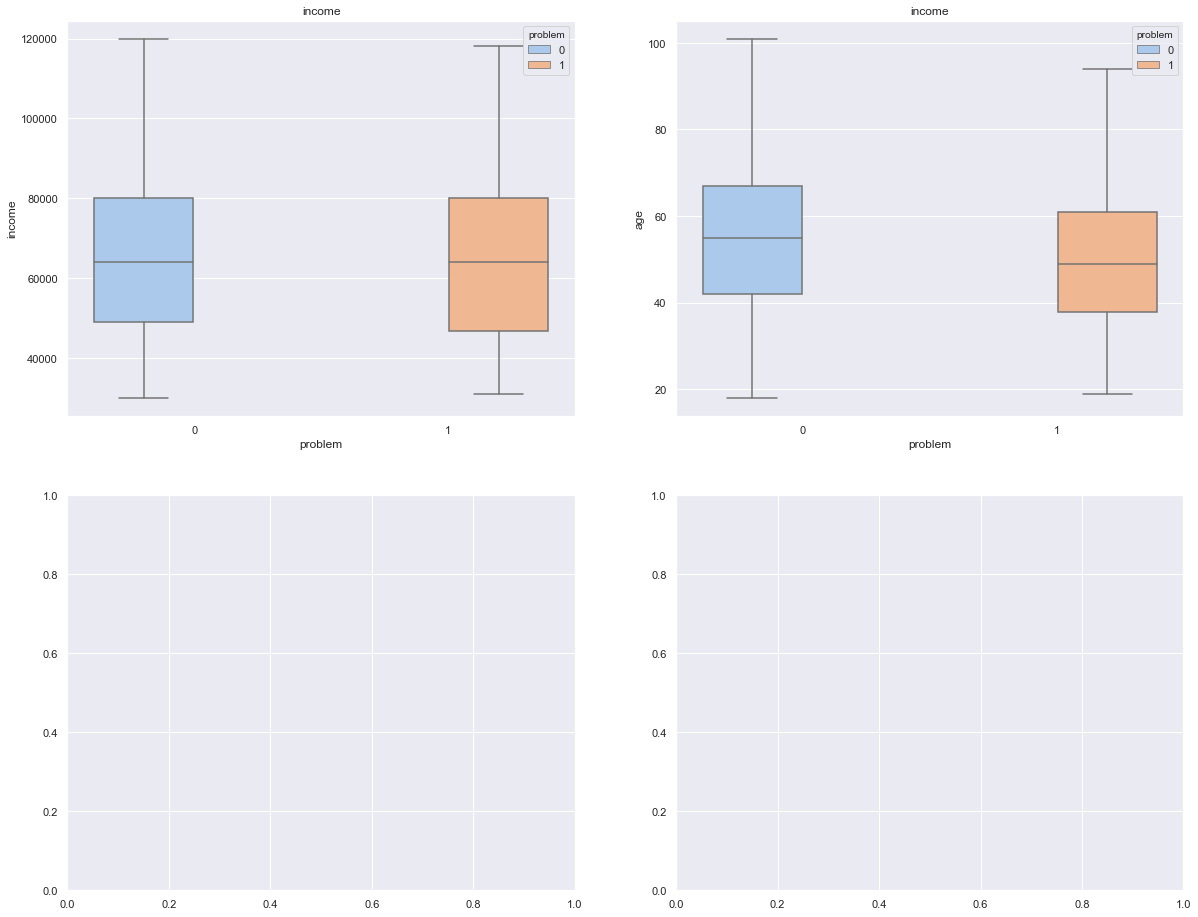

In [245]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 16))

sns.boxplot(x="problem", y = "income", hue="problem", data=profile_new, ax=axarr[0][0]).set_title("income")
sns.boxplot(x="problem", y = "age", hue="problem", data=profile_new, ax=axarr[0][1]).set_title("income")


In [ ]:
labels = '2017', '2018', 'recevied'
sizes = [len(offer0_3[offer0_3['event_id']==2]), len(offer0_3[offer0_3['event_id']==1]), len(offer0_3[offer0_3['event_id']==0])]
explode = (0.1, 0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customers interacted with bogo and discount offer")

plt.show()

In [219]:
o = Counter(offer1) & Counter(offer2)
o

Counter({'ae264e3637204a6fb9bb56bc8210ddfd': 27,
         '0b1e1539f2cc45b7b9fa7c272da2e1d7': 84,
         '2906b810c7d4411798c6938adc9daaa5': 38,
         'fafdcd668e3743c1bb461111dcafc2a4': 48,
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 18,
         '9b98b8c7a33c4b65b9aebfe6a799e6d9': 32,
         'f19421c1d4aa40978ebb69ca19b0e20d': 12,
         '2298d6c36e964ae4a3e7e9706d1fb8c2': 29})

In [221]:
portfolio[portfolio['id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7']
portfolio[portfolio['id'] == 'fafdcd668e3743c1bb461111dcafc2a4']

,reward,channels,difficulty,duration,offer_type,id
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4


In [286]:
# most valuable customers
amountBy_customers = full_df[['person', 'amount']].groupby(['person']).sum().reset_index()
eventBy_customers =full_df[['person', 'event', 'days']].groupby(['person', 'event']).count().reset_index()

amountBy_customers.sort_values('amount',  ascending=False)

,person,amount
3508,3c8d541112a74af99e88abbd0692f00e,1608.69
14014,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
10203,ae6f43089b674728a50b8727252d3305,1327.74
5692,626df8678e2a4953b9098246418c9cfa,1321.42
6690,73afdeca19e349b98f09e928644610f8,1319.97
...,...,...
11813,cbe6e55ecf54476db7504aee4ab74d0b,0.00
7471,8124f214cc314a44941899319f412502,0.00
3024,34e99d0c0bf242ef8cc4bb601c93fd16,0.00
9536,a328464197cf4c61a1f053fc28035a7c,0.00


In [284]:
eventBy_customers_new = eventBy_customers[eventBy_customers['event']=='offer completed']
eventBy_customers_new.sort_values('days',  ascending=False)

,person,event,days
55969,ffff82501cea40309d5fdd7edcca4a07,offer completed,6
27026,7ba2327c339f4081b2a94293df048b4d,offer completed,6
16367,4a8ee6675cbf4929833a61b6f0e5c539,offer completed,6
24531,7055b5fa5f8647618aa14e220b7c6b5c,offer completed,6
7067,2193267a91d747dfa7197bb39c78b2e5,offer completed,6
...,...,...,...
32393,93907d06a946424ba630487fe7aeafd1,offer completed,1
32385,938d98afcb894aeb8db9c60fca96ec58,offer completed,1
44867,ccfc5113eb5045639709024000f346ab,offer completed,1
17492,4fbb451301b54298a24590359c56c93b,offer completed,1


Text(0.5, 1, 'income')

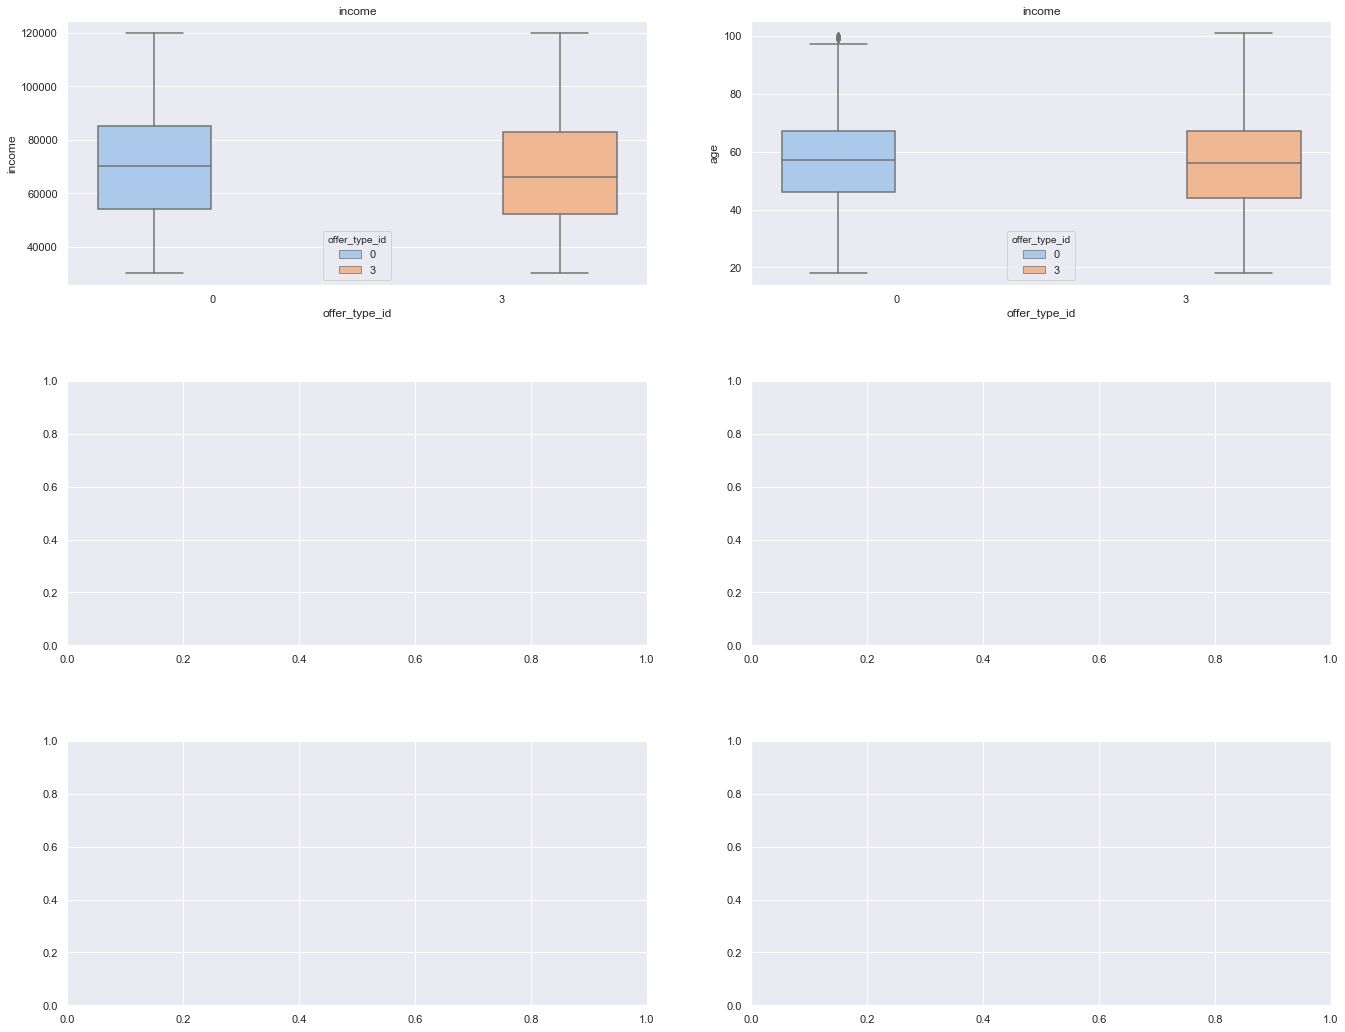

In [89]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 16))
fig.tight_layout(pad=6.0) #space between subplots

sns.set(palette='pastel',) #setting the color/style of our plots

sns.boxplot(y="income", x="offer_type_id", hue = 'offer_type_id', data=complete_first, ax=axarr[0][0]).set_title("income")
sns.boxplot(y="age", x="offer_type_id", hue = 'offer_type_id', data=complete_first, ax=axarr[0][1]).set_title("income")



In [65]:
bogo = offer0_3[offer0_3['offer_type_id']==0]
discount = offer0_3[offer0_3['offer_type_id']==3]
bogo_r = len(bogo[bogo['event_id']==2])/len(bogo[bogo['event_id']==0])
bogo_v = len(bogo[bogo['event_id']==2])/len(bogo[bogo['event_id']==1])
discount_r = len(discount[discount['event_id']==2])/len(discount[discount['event_id']==0])
discount_v = len(discount[discount['event_id']==2])/len(discount[discount['event_id']==1])

sizes = [len(offer0_3[offer0_3['event_id']==2]), len(offer0_3[offer0_3['event_id']==1]), len(offer0_3[offer0_3['event_id']==0])]
explode = (0.1, 0.1, 0)

print(bogo_r, bogo_v, discount_r, discount_v)

0.5749707954930852 0.6923181632560461 0.6445394539453946 0.9309354856183305


TypeError: unhashable type: 'numpy.ndarray'

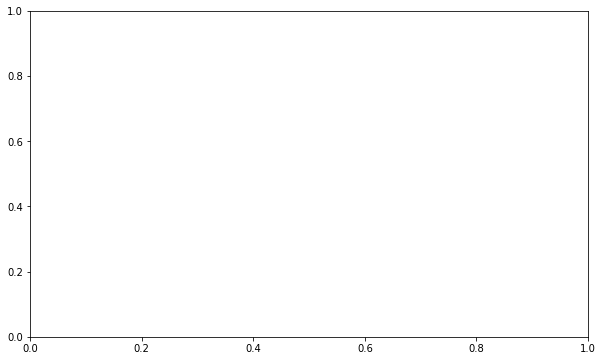

In [76]:
offers = offer_type['offer_type']
received= offer0_3[offer0_3['event_id']==0]
viewed = offer0_3[offer0_3['event_id']==1]
completed = offer0_3[offer0_3['event_id']==2]


plt.figure(figsize=(10,6))
ax=plt.subplot()

plt.bar(range(len(places)), received)
plt.bar(range(len(places)), viewed, bottom=received)
plt.bar(range(len(places)), completed, bottom=(received+viewed))

ax.set_xticks(range(len(places)))
ax.set_xticklabels(places, rotation = 90, fontsize=8)

#plt.title("\nOverview of the Coronavirus Outbreak in Different States/Provinces\n", fontsize=16)
#plt.ylabel("Total Infected cases\n", fontsize=14)
#plt.xlabel("Provinces/States", fontsize=14)
plt.legend(["Received",  "Viewed", "Completed"], loc=1)

plt.show()

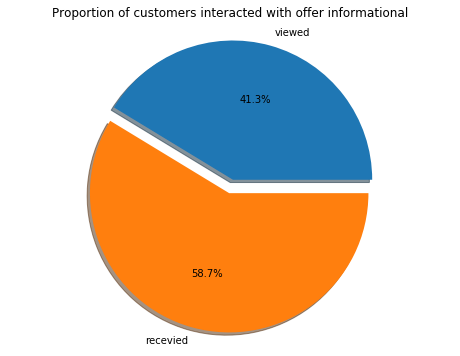

In [63]:
labels = 'viewed', 'recevied'
sizes = [len(offer1_n_amount[offer1_n_amount['event_id']==1]),len(offer1_n_amount[offer1_n_amount['event_id']==0])]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customers interacted with offer informational")

plt.show()

In [35]:
com_df.head(5)

,event,person,time,value,age,became_member_on,gender,income,amount,channels,difficulty,duration,offer_type,reward,event_id,offerType_id,channelType_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,0,1,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1,1,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75,20170509,F,100000.0,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,2,1,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,0,1,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,0.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1,1,1


In [49]:
by_customers = com_df[['person', 'amount']].groupby(['person']).agg(['sum', 'median', 'count']).rename(columns={'sum': 'sum', 'median': 'median','count': 'count'})

#by_customers.sort_values('sum', ascending=False).head(25)
by_customers


amount              
                                     sum  median count
person                                                
0009655768c64bdeb2e877511632db8f  127.60   0.000    20
0011e0d4e6b944f998e987f904e8c1e5   79.46   0.000    18
0020c2b971eb4e9188eac86d93036a77  196.86   0.000    19
0020ccbbb6d84e358d3414a3ff76cffd  154.05   6.810    23
003d66b6608740288d6cc97a6903f4f0   48.34   0.900    30
00426fe3ffde4c6b9cb9ad6d077a13ea   68.51   1.690    25
004b041fbfe44859945daa2c7f79ee64  138.36   0.000    13
004c5799adbf42868b9cff0396190900  347.38   0.000    26
005500a7188546ff8a767329a2f7c76a   20.36   0.000    13
0056df74b63b4298809f0b375a304cf4  144.14   0.000    15
00715b6e55c3431cb56ff7307eb19675  375.12  11.490    29
0082fd87c18f45f2be70dbcbb0fb8aad  121.85   0.000    18
00840a2ca5d2408e982d56544dc14ffd   62.93   1.250    28
00857b24b13f4fe0ad17b605f00357f5    6.26   0.000    12
008d7088107b468893889da0ede0df5c   16.18   0.000    18
0091d2b6a5ea4defaa8393e4e816db60  279.16   0.000    26
0099bf30e4cb4265875266eb3eb25eab  105.83   0.000    19
00a794f62b9a48beb58f8f6c02c2f1a6  166.40   2.980    22
00ae03011f9f49b8a4b3e6d416678b0b  218.05   0.000    23
00aee28bbb3848dd8a31f0c91dc267dd   20.53   0.940    10
00b18b535d6d4f779dea4dc9ac451478  133.25   0.000    18
00b3400e4ff64ee68ce9ada1d0c222f0  163.92   4.900    20
00b3c376db2a4115af3aef34a02f61d6  219.63   9.720    16
00b901d68f8f4fd68075184cd0f772d2   53.55   0.000    12
00bbce6533f44ddeaf4dd32bcab55441   77.21   0.000    18
00bc42a62f884b41a13cc595856cf7c3  150.64   0.000    22
00bc983061d3471e8c8e74d31b7c8b6f   63.50   0.000    10
00c20a9202d5475190b31a24de6fb06d  164.01   0.000    20
00c2f812f4604c8893152a5c6572030e  124.09   0.000    17
00c32a104f0c4065b5b552895fb22e34    6.98   0.000     9
...                                  ...     ...   ...
ff8bee9ba3754ac687d9af685b2981b7    0.00   0.000     6
ff8ff8e5d8bb449894bf708924020edc   96.74   0.000    22
ff932c6f8bb641bd816955337d153676  249.50   0.000    29
ff95e0a9cdfd4030958762dadcb11e1a   60.23   0.000    11
ff992fbec53145bbae59a68d025e0458   73.91   0.870    40
ff9beda564da4bab81633fca744037dc   77.19   0.000    18
ff9f73ead16a4f9b9e1a53a27280af92  263.30  10.570    26
ffa81afacde642a3a51a7cd99f8d2cd7  275.36   0.000    21
ffac285a64714aca8efd8d61a5606e84    9.63   0.000     8
ffaecba5bbb14cffb04c2490d18eee7e  174.33   0.000    22
ffb62bee02c14583b9763f8613bcace7   22.20   0.405    18
ffb7fc8ad0594248a49e210ff0217c2d  166.52   0.000    21
ffc60f10c2444740bc2049712bbffe17   19.92   0.000    13
ffc6c9fbe34b4578911dcdf6745b4c74    0.00   0.000     5
ffc77312ccda49fca19506f1cdf44923   33.77   0.835    16
ffc8a38e0972421785b00f80c92c8085  142.70   0.000    12
ffd53e5ba61d41378b66efc00d9f9682   89.44   1.370    24
ffd810f301ad42d6bfe98c4ba6ee4125    0.00   0.000     6
ffda4545e7084ff6aaf01304fb1c1fa6   43.76   0.000    12
ffdefcac307f4ca99ac1ebd51470f106  101.32   0.000    20
ffe5257abf8840b395e1ee6b29894637   63.49   0.000    14
ffeaa02452ef451082a0361c3ca62ef5  234.05   0.000    25
ffed75d3abc64b488982f50ed12878b5    0.00   0.000     4
fff0f0aac6c547b9b263080f09a5586a  116.90   6.435    12
fff29fb549084123bd046dbc5ceb4faa  291.47   0.000    28
fff3ba4757bd42088c044ca26d73817a  580.98   0.000    23
fff7576017104bcc8677a8d63322b5e1   29.94   0.000    18
fff8957ea8b240a6b5e634b6ee8eafcf   12.15   0.320    10
fffad4f4828548d1b5583907f2e9906b   88.83   2.050    23
ffff82501cea40309d5fdd7edcca4a07  226.07   0.000    33

[14825 rows x 3 columns]